In [1]:
import dingo
import os
import cobra
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pylab as plt
import random

In [2]:
main_path = '/'.join(os.getcwd().split("/")[:-1])

In [3]:
cobra_config = cobra.Configuration()
cobra_config.solver = 'glpk'

Sample without maximizing for any particular reaction.
To do so, set a zero vector as the objective function. 
The default objective function of the model is VBOF.

In [ ]:
# Load model
model = dingo.MetabolicNetwork.from_sbml(main_path + '/ext_data/iAB_AMO1410_SARS-CoV-2.xml')

# Set the unbiased objective function
zero_biomass_function = np.zeros( model.num_of_reactions() )
model.set_biomass_function = zero_biomass_function

Now sample on the flux space in an unbiased way as no maximization is performed. 
In case, `gurobi` is not available, use the `set_slow_mode()` function, otherwise mute this line.

In [ ]:
# Generate steady states - 
sampler = dingo.PolytopeSampler(model)
sampler.set_slow_mode()
unbiased_steady_states = sampler.generate_steady_states()

with open("unbiased_sars_model_samples.pckl", "wb") as dingo_steadystates_file: 
     pickle.dump(unbiased_steady_states, dingo_steadystates_file)

Now, let us sample after maximizing the virus biomass (VBOF).

In [24]:
# Load model
vbof_model = dingo.MetabolicNetwork.from_sbml(main_path + '/ext_data/iAB_AMO1410_SARS-CoV-2.xml')

# Get information about the biomass functions
covid_biomass_index = vbof_model.biomass_index
human_biomass_index = covid_biomass_index - 1

Set parameter Username


VBOF is already the objective function of your model. 

In [ ]:
# Sample optimal steady states when the objective function represents the virus' growth rate
vbof_sampler = dingo.PolytopeSampler(vbof_model)
vbof_sampler.set_slow_mode()
steady_states_covid_max_biomass = vbof_sampler.generate_steady_states()

with open("max_vbof_sars_model_samples.pckl", "wb") as dingo_steadystates_file: 
         pickle.dump(steady_states_covid_max_biomass, dingo_steadystates_file)

For this case, you can also optimize your model; i.e. run FBA.  

In [40]:
# The dingo fba() function returns a tuple with a single element
vbof_fba = vbof_model.fba()[0]

Finally, sample after maximizing for the human biomass function. 

In [26]:
# Load model
human_biomass_model = dingo.MetabolicNetwork.from_sbml(main_path + '/ext_data/iAB_AMO1410_SARS-CoV-2.xml')

# set the objective function to be the human's biomass function
human_biomass_function = np.zeros(human_biomass_model.num_of_reactions())
human_biomass_function[human_biomass_index] = 1
human_biomass_model.set_biomass_function = human_biomass_function

Set parameter Username


Again, if you have `gurobi` mute the `set_slow_mode()` function.

In [ ]:
# sample optimal steady states when the objective function is the human's biomass function
human_biomass_sampler =  dingo.PolytopeSampler( human_biomass_model )
human_biomass_sampler.set_slow_mode()
steady_states_human_max_biomass = human_biomass_sampler.generate_steady_states()

with open("max_human_biomass_sars_model_samples.pckl", "wb") as dingo_steadystates_file: 
         pickle.dump(steady_states_human_max_biomass, dingo_steadystates_file)

And, like in the vbof case, optimize your model with human biomass as the objective function.

In [39]:
human_biomass_fba = human_biomass_model.fba()[0]

In case samples are already saved as above, you can just load your samples by running: 

In [169]:
unbiased_steady_states = pickle.load(open( "sars_samples/unbiased_sars_model_samples.pckl", "rb"))
vbof_max_samples = pickle.load(open("sars_samples/max_vbof_sars_model_samples.pckl", "rb"))
human_biomass_max_samples = pickle.load(open("sars_samples/max_human_biomass_sars_model_samples.pckl", "rb"))

Now, calculate the mean value of the flux value of each reaction.

In [170]:
vbof_max_samples_mean = vbof_max_samples.mean( axis = 1 )
human_biomass_max_samples_mean = human_biomass_max_samples.mean( axis = 1)

And plot an histogram for each of these cases to see the distribution. 

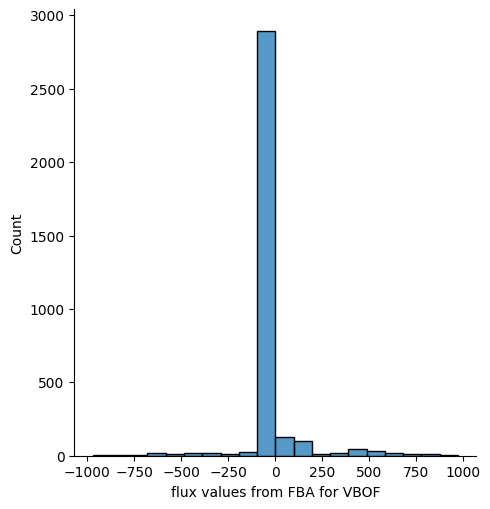

In [51]:
ax = sn.displot(vbof_max_samples_mean, bins=20)
ax.set(xlabel = 'flux values from FBA for VBOF')
plt.show()

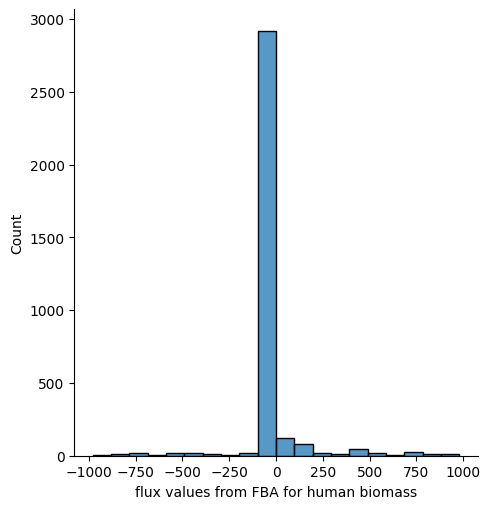

In [52]:
ax = sn.displot(human_biomass_max_samples_mean, bins=20)
ax.set(xlabel = 'flux values from FBA for human biomass')
plt.show()


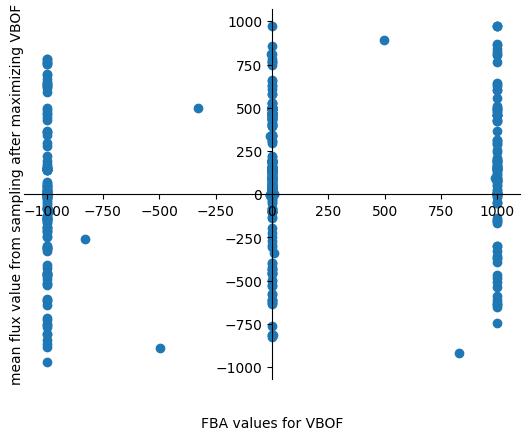

In [42]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('FBA values for VBOF')
plt.ylabel('mean flux value from sampling after maximizing VBOF')
ax.xaxis.set_label_coords(0.5, -.1)
ax.yaxis.set_label_coords(0, 0.5)
plt.scatter(x = vbof_fba, y = vbof_max_samples_mean)

Apparentrly, that is rather intriguing and not a good sign for the FBA predictions. 
Therefore, let's have a look in a simpler model, that of a microbial species. 
We'll use several AGORA models to check if that is the case. 

In [ ]:
agora_models_dir = "/home/luna.kuleuven.be/u0156635/github_repos/model_selector/agora_models"
random_model_indices = random.sample(range(0, len(os.listdir(agora_models_dir))), 10)
index = 0
counter = 0
for mfile in os.listdir(agora_models_dir):

    if index in random_model_indices:

        model_file = agora_models_dir + "/" + mfile    
        bac_model = dingo.read_mat_file( model_file )
        bac_model_obj = dingo.MetabolicNetwork( bac_model )
       
        sampler = dingo.PolytopeSampler( bac_model_obj )
        sampler.set_slow_mode()

        try: 
            samples = sampler.generate_steady_states( psrf=1.3, ess = 500, num_threads = 8 )
        except:
            print("!!!!  sampling was NOT completed!")
            del bac_model_obj
            continue
        
        with open("agora_samples/" + mfile[:-4] + ".pckl", "wb") as dingo_steadystates_file: 
            pickle.dump(samples, dingo_steadystates_file)

        del samples ; del bac_model_obj ; del sampler

        counter += 1

    index += 1

In [13]:
list_of_solutions = [ ]
species_names = [ ]
list_of_mean_sampling_solutions = [ ]

import cobra 
cobra_config = cobra.Configuration()
cobra_config.solver = 'glpk'

agora_models_dir = "/home/luna.kuleuven.be/u0156635/github_repos/model_selector/agora_models"
for mfile in os.listdir("agora_samples/"):

    print(mfile)
    model_file = agora_models_dir + "/" + mfile[:-4] + "mat"
    species_names.append(mfile[:-4])

    print("optimize") # we use cobra to highlight that is is not a dingo issue 
    cobra_model = cobra.io.load_matlab_model(model_file)
    solution = cobra_model.optimize().fluxes
    list_of_solutions.append(solution)

    print("get mean")
    species_samples = pickle.load(open("agora_samples/" + mfile, "rb"))
    mean_values = species_samples.mean( axis = 1 )
    list_of_mean_sampling_solutions.append(mean_values)



No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Yersinia_bercovieri_ATCC_43970.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Blautia_obeum_ATCC_29174.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Clostridium_botulinum_F_str_230613.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Roseburia_hominis_A2_183.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Corynebacterium_ureicelerivorans.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Rhodococcus_rhodochrous_ATCC_21198.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Peptostreptococcus_anaerobius_DSM_2949.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Clostridium_tyrobutyricum_DSM_2637.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Streptococcus_anginosus_1_2_62CV.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Bifidobacterium_mongoliense_DSM_21395.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Prevotella_stercorea_DSM_18206.pckl
optimize


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


get mean
Halococcus_morrhuae_DSM1307.pckl
optimize
get mean


Now make a grid plot for all the 20 random models that were optimized and sampled.

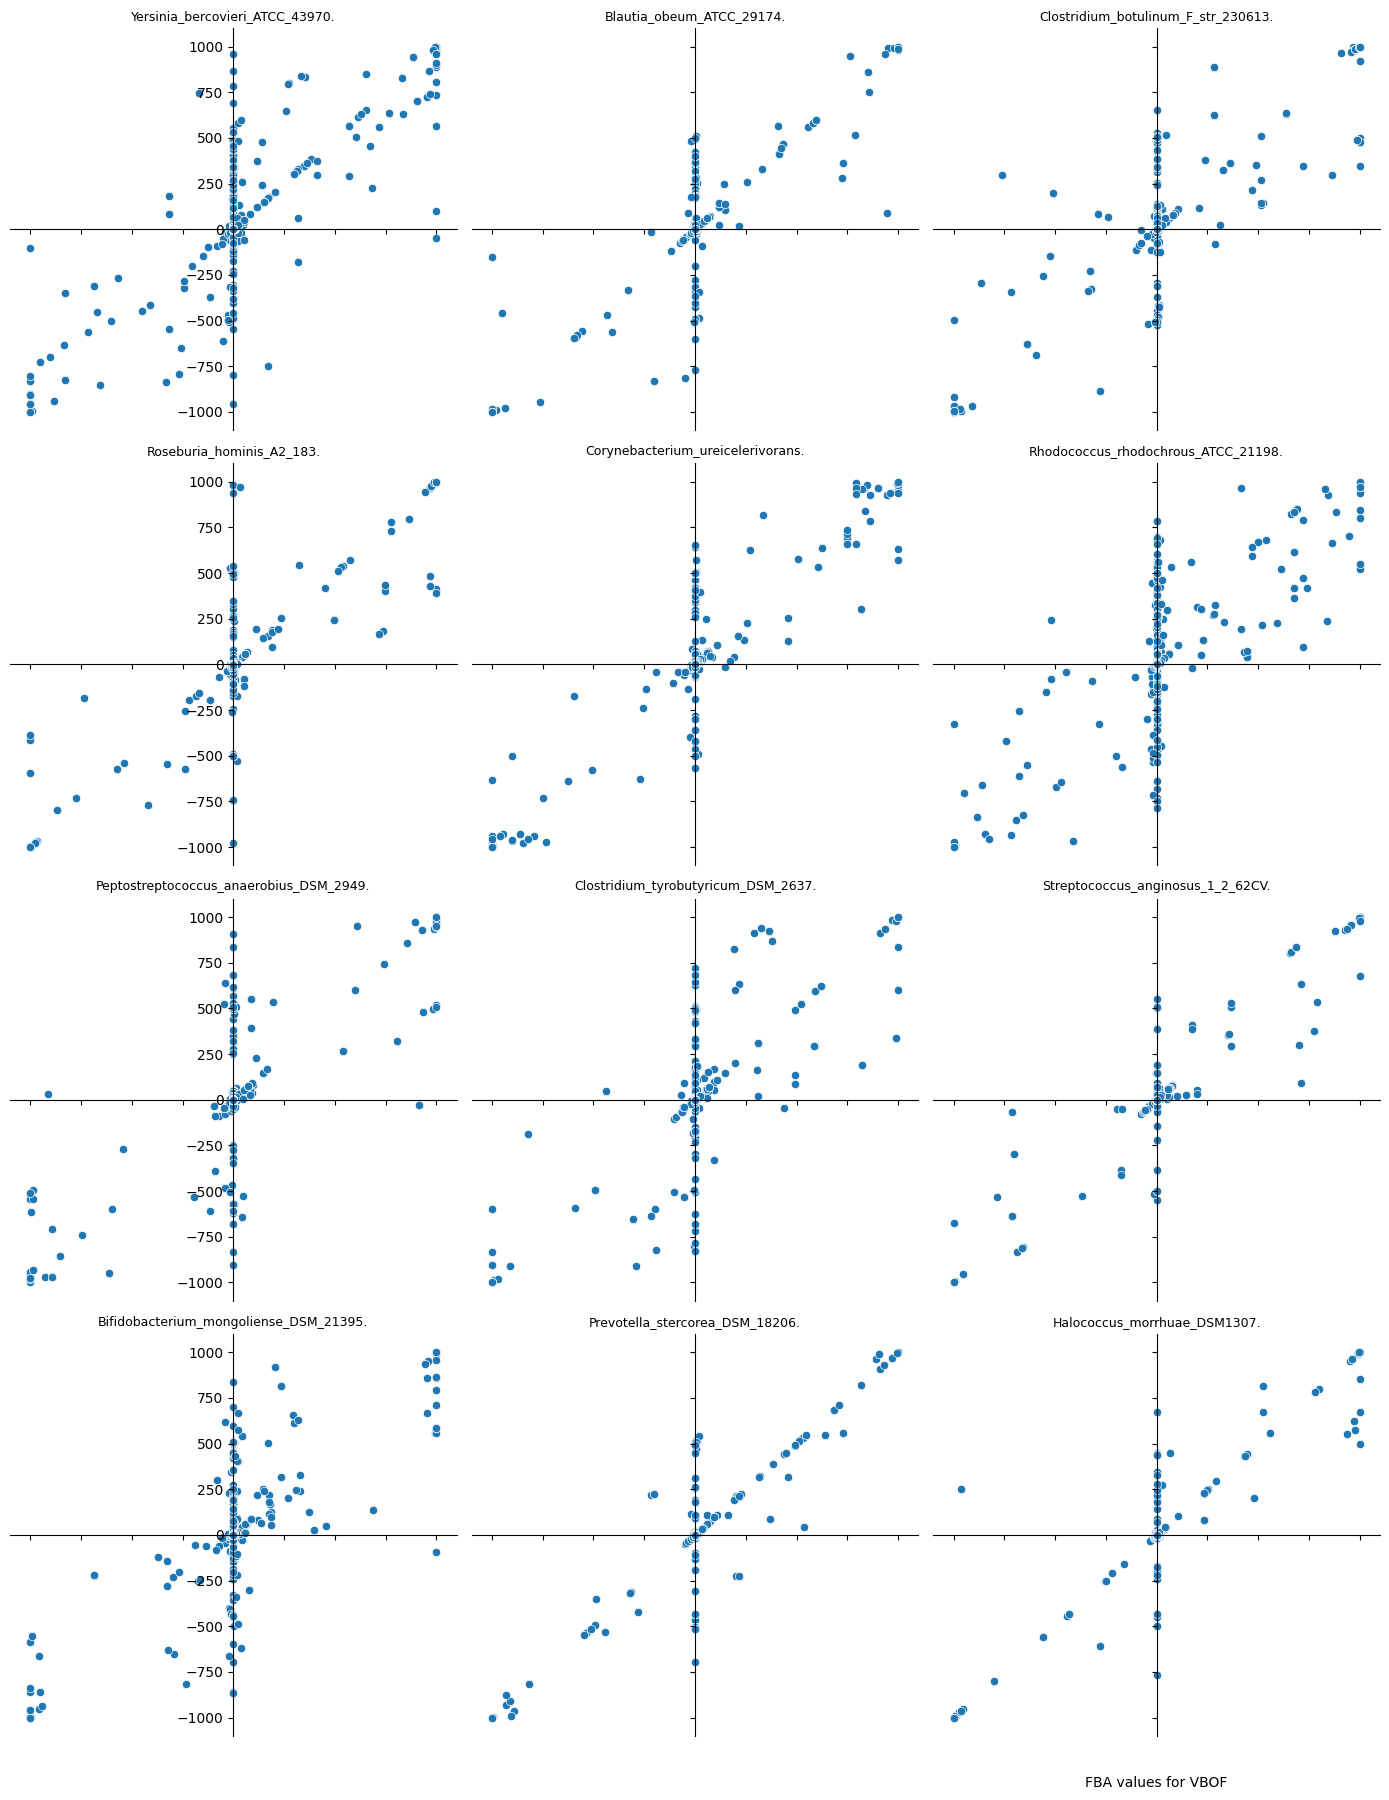

In [19]:
fig, axes = plt.subplots(4, 3, figsize=(14, 18), sharex=True, sharey=True)
axes = axes.flat

counter = 0
for ax, solution in zip( axes, list_of_solutions ):

    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    ax.xaxis.set_label_coords(0.5, -.1)
    ax.yaxis.set_label_coords(0, 0.5)

    sn.scatterplot(x = solution, y = list_of_mean_sampling_solutions[counter], ax = ax) 
    sn.despine(top=True, right=True)
    ax.set(xlabel=None)

    ax.set_title(species_names[counter], fontsize=9)
    ax.xaxis.set_ticklabels([])
    counter += 1


plt.xlabel('FBA values for VBOF')
plt.ylabel('mean flux value from sampling after maximizing VBOF')

fig.tight_layout()
fig.savefig('scatter.svg')
  
